In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from keras.applications import VGG16
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from xgboost import XGBClassifier
from keras.preprocessing.image import ImageDataGenerator

The features that have been selected by evaluating the importance of the features. They include the coordinates of the human joints, the angles between ajacent limbs and the distance metrics between pairs of joints.

In [ ]:
a = ['3_7', '1_4', '4_6', '3_14', '2_7', '7_8', '14_15', '3_8', '7_11', '6_17', '4_8', '3_11', '3_6', '4_11', '5_6', '6_8', '1_5', '0_15', 
     '4_5', '6_11', '16_17', '4_7', '2_3_4', '1_5_6', '5_6_7', '0_1_2', '1_2_3', '1_5_11', '1_2_8', '0_1_5', '7_x', '7_y', '6_x', '8_y', 
     '6_y', '11_x', '1_x', '4_x', '2_x', '3_y', '16_x', '4_y', '17_x', '5_y', '8_x', '16_y', '5_x']

dis = ['3_7', '1_4', '4_6', '3_14', '2_7', '7_8', '14_15', '3_8', '7_11', '6_17', '4_8', '3_11', '3_6', '4_11', '5_6', '6_8', '1_5', '0_15', 
     '4_5', '6_11', '16_17', '4_7']
coor = ['7_x', '7_y', '6_x', '8_y', '6_y', '11_x', '1_x', '4_x', '2_x', '3_y', '16_x', '4_y', '17_x', '5_y', '8_x', '16_y', '5_x']
angle = ['2_3_4', '1_5_6', '5_6_7', '0_1_2', '1_2_3', '1_5_11', '1_2_8', '0_1_5', ]
print('coor {} - dis {} - angel {} - all {}'.format(len(dis), len(coor), len(angle), len(dis) + len(coor) + len(angle)))

coor 22 - dis 17 - angel 8 - all 47


Define the VGG16 model as one of the resources of data for ensemble-based action recognition.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(5, activation='softmax'))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Load the weights for the VGG16 model that has been trained on the Image-based action recognition dataset.

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])
model1.load_weights('Models/VGG16_action_weights.h5')

Load the image the image-based dataset.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('Dataset/train', target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False)
validation_generator = test_datagen.flow_from_directory('Dataset/validation', target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False)
test_generator = test_datagen.flow_from_directory('Dataset/test', target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False)

Found 1315 images belonging to 5 classes.
Found 330 images belonging to 5 classes.
Found 410 images belonging to 5 classes.


In [3]:
x1, y1 = zip(*(train_generator[i] for i in range(len(train_generator))))
X_train1, Y_train1 = np.vstack(x1), np.vstack(y1)

x1, y1 = zip(*(validation_generator[i] for i in range(len(validation_generator))))
X_val1, Y_val1 = np.vstack(x1), np.vstack(y1)

x1, y1 = zip(*(test_generator[i] for i in range(len(test_generator))), test_generator.filenames)
X_test1, Y_test1 = np.vstack(x1), np.vstack(y1)

In [4]:
X_train1, y_train1, img_add = [], [], []
counter = 0
for idx1, (x, y) in enumerate(train_generator):
  for idx2, (i, j) in enumerate(zip(x, y)):
    print(i.shape)
    X_train1.append(model1.predict(np.expand_dims(i, axis=0)))
    y_train1.append(j)
#     print(idx1 * 32 + idx2)
    img_add.append(train_generator.filenames[counter])
    counter += 1
    if counter == 1315:
      break
      
  if counter == 1315:
    break


X_val1, y_val1, img_val_add = [], [], []
counter = 0
for idx1, (x, y) in enumerate(validation_generator):
  for idx2, (i, j) in enumerate(zip(x, y)):
    print(i.shape)
    X_val1.append(model1.predict(np.expand_dims(i, axis=0)))
    y_val1.append(j)
    img_val_add.append(validation_generator.filenames[counter])
    counter += 1
    if counter == 330:
      break
      
  if counter == 330:
    break


X_test1, y_test1, img_test_add = [], [], []
counter = 0
for idx1, (x, y) in enumerate(test_generator):
  for idx2, (i, j) in enumerate(zip(x, y)):
    print(i.shape)
    X_test1.append(model1.predict(np.expand_dims(i, axis=0)))
    y_test1.append(j)
    img_test_add.append(test_generator.filenames[counter])
    counter += 1
    if counter == 410:
      break
      
  if counter == 410:
    break

In [ ]:
X_train1 = X_train1 + X_val1
img_add = img_add + img_val_add
y_train1 = y_train1 + y_val1

Data for All Angles and All Dist and All Scaled Coordinations for Five-class Dataset

In [ ]:
train_csv = pd.read_csv(r"Dataset/allDist_allAngles_allScaled_train.csv")
train_csv_copy = train_csv.copy()
train_csv_copy = train_csv_copy.sample(frac=1, random_state=42)

test_csv = pd.read_csv(r"Dataset/allDist_allAngles_allScaled_test.csv")
test_csv_copy = test_csv.copy()
test_csv_copy = test_csv_copy.sample(frac=1, random_state=42)

In [5]:
from numpy import sort
from sklearn.utils import shuffle

zipped = zip(img_add, X_train1, y_train1)
zipped = sorted(zipped)
img_add_temp, X_train1_temp, y_train1_temp = zip(*zipped)
train_csv_copy.sort_values('img_address', inplace=True)
img_add_temp = [i.split('/')[-1] for i in img_add_temp]
train_csv_copy['img_address'] = train_csv_copy['img_address'].str.split('/').str[-1]

zipped = zip(img_test_add, X_test1, y_test1)
zipped = sorted(zipped)
img_test_add_temp, X_test1_temp, y_test1_temp = zip(*zipped)
test_csv_copy.sort_values('img_address', inplace=True)
img_test_add_temp = [i.split('/')[-1] for i in img_test_add_temp]
test_csv_copy['img_address'] = test_csv_copy['img_address'].str.split('/').str[-1]

train_csv_copy = train_csv_copy.sample(frac=1, random_state=42)
test_csv_copy = test_csv_copy.sample(frac=1, random_state=42)

temp = list(zip(img_add_temp, X_train1_temp, y_train1_temp))
temp = shuffle(temp, random_state=42)
img_add_temp, X_train1_temp, y_train1_temp = zip(*temp)
img_add_temp = list(img_add_temp)


temp = list(zip(img_test_add_temp, X_test1_temp, y_test1_temp))
temp = shuffle(temp, random_state=42)
img_test_add_temp, X_test1_temp, y_test1_temp = zip(*temp)
img_test_add_temp = list(img_test_add_temp)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('Dataset/test2', target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False)

X_test1, y_test1, img_test_add = [], [], []
counter = 0
for idx1, (x, y) in enumerate(test_generator):
  for idx2, (i, j) in enumerate(zip(x, y)):
    print(i.shape)
    X_test1.append(model1.predict(np.expand_dims(i, axis=0)))
    y_test1.append(j)

    img_test_add.append(test_generator.filenames[counter])
    counter += 1
    if counter == 527:
      break
      
  if counter == 527:
    break

In [ ]:
X_train2 = train_csv_copy.drop(['img_address', 'action_class'], axis=1)
y_train2 = train_csv_copy.action_class

X_test2 = test_csv_copy.drop(['img_address', 'action_class'], axis=1)
y_test2 = test_csv_copy.action_class

Best features for All Angles and All Dist and All Scaled Coordinations for Five-class Dataset

In [ ]:
X_train2 = X_train2[['3_7', '1_4', '4_6', '3_14', '2_7', '7_8', '14_15', '3_8', '7_11', '6_17', '4_8', '3_11', '3_6', '4_11', '5_6', '6_8', '1_5', '0_15', '4_5', '6_11', '16_17', '4_7', '2_3_4', '1_5_6', '5_6_7', '0_1_2', '1_2_3', '1_5_11', '1_2_8', '0_1_5', '7_x', '7_y', '6_x', '8_y', '6_y', '11_x', '1_x', '4_x', '2_x', '3_y', '16_x', '4_y', '17_x', '5_y', '8_x', '16_y', '5_x']]
X_test2 = X_test2[['3_7', '1_4', '4_6', '3_14', '2_7', '7_8', '14_15', '3_8', '7_11', '6_17', '4_8', '3_11', '3_6', '4_11', '5_6', '6_8', '1_5', '0_15', '4_5', '6_11', '16_17', '4_7', '2_3_4', '1_5_6', '5_6_7', '0_1_2', '1_2_3', '1_5_11', '1_2_8', '0_1_5', '7_x', '7_y', '6_x', '8_y', '6_y', '11_x', '1_x', '4_x', '2_x', '3_y', '16_x', '4_y', '17_x', '5_y', '8_x', '16_y', '5_x']]

Params for Training all Angles all Dist all coordinates scaled best features on Five-class Dataset with 200 comb

In [ ]:
model2 = XGBClassifier(subsample=0.8, n_estimators=150, min_child_weight=1, max_depth=4, learning_rate=0.05, gamma=1, colsample_bytree=0.6, objective='multi:softmax', silent=True, num_class=5)

In [ ]:
model2 = model2.fit(X_train2, y_train2)

In [ ]:
X_train2_temp = model2.predict_proba(X_train2)
X_test2_temp = model2.predict_proba(X_test2)

(1645, 5)


Create the stacked dataset as input for the ensemble model.

In [ ]:
stack_train_X = np.dstack((X_train2_temp, np.reshape(list(X_train1_temp), (1645, 5))))
stack_train_X = stack_train_X.reshape((stack_train_X.shape[0], stack_train_X.shape[1]*stack_train_X.shape[2]))

stack_test_X = np.dstack((X_test2_temp, np.reshape(list(X_test1_temp), (410, 5))))
stack_test_X = stack_test_X.reshape((stack_test_X.shape[0], stack_test_X.shape[1]*stack_test_X.shape[2]))

[7.2514237e-04 5.4738135e-03 9.9193853e-01 1.0151033e-03 8.4745727e-04]
(410, 5)
[[1.2589811e-04 9.8778802e-01 6.2186189e-04 1.3425935e-04 1.1329971e-02]]
(1645, 10)
(410, 10)


In [ ]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack

Train a Logistic Regression model over the ensembled dataset.

In [7]:
model = LogisticRegression()
model.fit(stack_train_X, y_train2)

import pickle
pickle.dump(model, open('Models/ensemble.sav', 'wb'))

y_pred = model.predict(stack_test_X)
y_pred_prob = model.predict_proba(stack_test_X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(stack_test_X, y_test2)))

Visualizing the Confusion Matrix

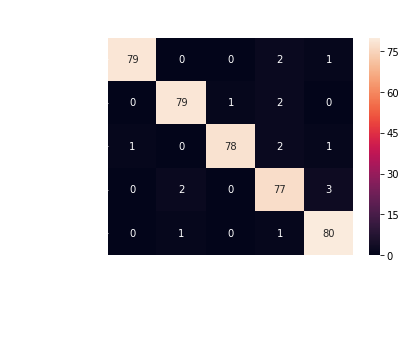

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


Y_pred = np.argmax(y_pred_prob, axis=1)
Y_test = np.argmax(y_test1_temp, axis=1)

target_names = ['arms crossed', 'arms up', 'arms wide open', 'hands on hips', 'neutral']

cm = confusion_matrix(Y_test, Y_pred)

cm_df = pd.DataFrame(cm, index = ['arms crossed', 'arms up', 'arms wide open', 'hands on hips', 'neutral'], columns = ['arms crossed', 'arms up', 'arms wide open', 'hands on hips', 'neutral'])


fig = plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('five class Ensemble Model\nAccuracy:{0:.3f}'.format(accuracy_score(Y_test, Y_pred))).set_color('white')
plt.ylabel('True label').set_color('white')
plt.xlabel('Predicted label').set_color('white')
#plt.xaxis.label.set_color('White')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

Showing the misclassified samples based on their class

In [ ]:
for i, j, k in zip(Y_pred, Y_test, img_test_add_temp):
  if i != j and i == 0:
    print(k)
print('--------')

for i, j, k in zip(Y_pred, Y_test, img_test_add_temp):
  if i != j and i == 1:
    print(k)
print('--------')

for i, j, k in zip(Y_pred, Y_test, img_test_add_temp):
  if i != j and i == 2:
    print(k)
print('---------')

for i, j, k in zip(Y_pred, Y_test, img_test_add_temp):
  if i != j and i == 3:
    print(k)

print('--------')
for i, j, k in zip(Y_pred, Y_test, img_test_add_temp):
  if i != j and i == 4:
    print(k)

410
410
410
armsWideOpen_571.jpg
--------
handsOnHips_421.png
handsOnHips_261.jpg
neutral_237.jpg
--------
armsUp_187.jpg
---------
neutral_276.jpeg
armsCrossed_275.jpg
armsUp_516.jpeg
armsUp_154.jpg
armsWideOpen_278.jpg
armsCrossed_373.jpg
armsWideOpen_249.jpg
--------
handsOnHips_494.jpg
armsCrossed_156.jpg
armsWideOpen_568.jpg
handsOnHips_125.jpg
handsOnHips_161.jpg
